<a href="https://colab.research.google.com/github/dylanoco/basketball-classification-dribbling/blob/master/creating_ts_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Running Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import glob
from sktime.datasets import write_ndarray_to_tsfile
from sklearn.model_selection import train_test_split
import os
import math
import random
import tensorflow as tf

In [ ]:
!pip install --upgrade sktime

## The Process of Creating a Dataset

I will be using dummy data I created by moving my arm around for twelve seconds.
This will be used to help me convert the CSV file recieved into a compatable .ts file type to be used for training.
Once I have done this for the Accelerometer, Gyroscope and then finally both of them combined, I will proceed to create the actual training and testing dataset for the models.

In [ ]:
# Converting CSV into a DataFrame for manipulation
df_accel_data = pd.read_csv('/content/drive/MyDrive/Development_Project/dummy_data/Accelerometer.csv')
#df_gyro_data = pd.read_csv('/content/drive/MyDrive/Development_Project/dummy_data/Gyroscope.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Development_Project/dummy_data/Accelerometer.csv'

In [ ]:
#Resampling the Seconds
df_accel_data['seconds_elapsed'] = pd.to_datetime(df_accel_data['seconds_elapsed'], unit='s')

df_accel_data.set_index('seconds_elapsed', inplace=True)

df_resampled = df_accel_data.resample('S').mean()

df_resampled.reset_index(inplace=True)

df_resampled['seconds_elapsed'] = df_resampled['seconds_elapsed'].astype(int) / 1e6

# Print the resampled DataFrame
print(df_resampled)


## Dropping Columns

Now, I must drop the necessary columns so that I only remain with; z,y and x.

In [ ]:
df_accel_data = df_accel_data.drop(columns=['time','seconds_elapsed'])

In [ ]:
df_resampled = df_resampled.drop(columns=['time','seconds_elapsed'])

## Normalisation; MinMax()

I will apply Normalisation to this data. This will help with consistency in the future and aid in combatting biases the model may develop during training.

In [ ]:
scaler = MinMaxScaler()

# Selecting the axes, scaling them with MinMaxScaler
df_resampled[['z', 'y', 'x']] = scaler.fit_transform(df_resampled[['z', 'y', 'x']])

## Establishing the labels (Y)

Of course, each instance needs a label for the Classification models to be able to identify the movement performed.

In [ ]:
label = 'test_1'

## Exporting the data

Finally, we want to be able to export this data into a suitable format. I have decided to use the .ts format from SKTime.

A Time-Series file requires data in the format, specified in the documentation;
"The dataset in a 3d ndarray to be written as a ts file which must be of the structure specified in the documentation examples/loading_data.ipynb. (n_instances, n_columns, n_timepoints)"

As a result, I need to transpose the data so that the rows and columns are essentially flipped; 3 rows, n columns (n being the amount of timepoints, the 'rows' in this case are the columns z,y and x.)

Then, once inserted into the array, the shape will match the format required

*   (1 instance, 3 rows, n columns)
*   "(n_instances, n_columns, n_timepoints)"


In [ ]:
df_resampled = np.transpose(df_resampled)

In [ ]:




X = []
y = []
X.append(df_resampled)
y.append(label)
X = np.asarray(X)
y = np.asarray(y)
sy = set(y)

file_path = '/content/drive/MyDrive/Development_Project/'
write_ndarray_to_tsfile(data = X, path = file_path, problem_name='sample_data', class_label=sy,class_value_list=y)

## Allowing for more than one instance.

Now that we can successfully create one instance of a movement, insert it into a dataset and create that dataset, we now need to make it capable of iterating through numerous instances.

This will consist of creating a loop, iterating through a folder of CSV files, preprocessing each one of them and appending it into the list.

Once completed, we then convert that list into a numpy Array to then be packed away as a Time-Series dataset !

In [ ]:
import os
import random

In [ ]:
X = []
y = []

In [ ]:

path = '/content/drive/MyDrive/Development_Project/dummy_data/'
files = os.listdir(path)
for file in files:

  df_accel_data = pd.read_csv(path+file)
  df_accel_data['seconds_elapsed'] = pd.to_datetime(df_accel_data['seconds_elapsed'], unit='s')
  df_accel_data.set_index('seconds_elapsed', inplace=True)
  df_resampled = df_accel_data.resample('S').mean()
  df_resampled.reset_index(inplace=True)
  df_resampled['seconds_elapsed'] = df_resampled['seconds_elapsed'].astype(int) / 1e6

  df_resampled = df_resampled.drop(columns=['time','seconds_elapsed'])

  scaler = MinMaxScaler()
  # Selecting the axes, scaling them with MinMaxScaler
  df_resampled[['z', 'y', 'x']] = scaler.fit_transform(df_resampled[['z', 'y', 'x']])

  df_resampled = np.transpose(df_resampled)

  X.append(df_resampled)
  y.append(label + str(random.randint(0,5)))

X = np.asarray(X)
y = np.asarray(y)
sy = set(y)

file_path = '/content/drive/MyDrive/Development_Project/'
write_ndarray_to_tsfile(data = X, path = file_path, problem_name='sample_data', class_label=sy,class_value_list=y)





## End Result

We now have an ndarray with a shape of (4,3,13); 4 Instances (I had 4 CSV Files in one folder), 3 Columns (X,Y, and Z) and 13 Timepoints (Recorded at 12 seconds but the 0th second is included).

We can now record as many instances as we want, insert it into a folder of our choice and generate a time-series dataset.
## Part 2
However, not only are we going to record individual datasets (one for accelerometer and another for gyroscope), we also need to combine the two.

As a result, we need to;
* Be able to iterate through folders
* differentiate between Accelerometer and Gyroscope csv files
* rename the columns and combine the two dataframes together to count as one instance!



In [ ]:
import glob
dir_path = '/content/drive/MyDrive/Development_Project/dummy_data/'
files = os.listdir(path)

X = []
y = []

for root,files,dir in os.walk(dir_path): #This allows us to walk through the folder that has more folders(instances)
  for name in files: #Gets the name of the folders
    path = os.path.join(dir_path,name)
    folder_files = os.listdir(path)
    count = 0
    df_list = []
    for file in folder_files: #Grabs the individual names of the files within that folder
      file_name = file.split(".") #Allows us to split the name of the file from the file type extension
      #Standard Preprocessing from earlier
      df_accel_data = pd.read_csv(os.path.join(path,file))
      df_accel_data['seconds_elapsed'] = pd.to_datetime(df_accel_data['seconds_elapsed'], unit='s')
      df_accel_data.set_index('seconds_elapsed', inplace=True)
      df_resampled = df_accel_data.resample('S').mean()
      df_resampled.reset_index(inplace=True)
      df_resampled['seconds_elapsed'] = df_resampled['seconds_elapsed'].astype(int) / 1e6
      df_resampled = df_resampled.drop(columns=['time','seconds_elapsed'])
      #By using .split(), we can get the name of the file and rename the columns as neccessary.
      if(file_name[0] == "Accelerometer"):
        df_resampled.rename(columns={"z":"accel_z", "y": "accel_y", "x": "accel_x"},inplace=True)
        print(df_resampled.columns)
        scaler = MinMaxScaler()
        # Selecting the RENAMED axes
        df_resampled[['accel_z', 'accel_y', 'accel_x']] = scaler.fit_transform(df_resampled[['accel_z', 'accel_y', 'accel_x']])
      else: #Same process for Gyroscope
        df_resampled.rename(columns={"z": "gyro_z", "y": "gyro_y", "x": "gyro_x"},inplace=True)
        print(df_resampled.columns)
        scaler = MinMaxScaler()
        df_resampled[['gyro_z', 'gyro_y', 'gyro_x']] = scaler.fit_transform(df_resampled[['gyro_z', 'gyro_y', 'gyro_x']])

      df_list.append(df_resampled)
      count += 1

    df_total = pd.concat(df_list, axis=1, join='inner')
    df_total = np.transpose(df_total)
    X.append(df_total)
    y.append(label + str(random.randint(0,10)))

X = np.asarray(X)
y = np.asarray(y)
sy = set(y)

file_path = '/content/drive/MyDrive/Development_Project/'
write_ndarray_to_tsfile(data = X, path = file_path, problem_name='sample_data_combined', class_label=sy,class_value_list=y)

## 2 Second Instances

My goal here is to be able to collect 2 second instances (roughly the time it takes to perform a dribble move) from one set of data so that I can get more accurate results of the movement being performed than taking 10 seconds (for example) of data which includes me performing the move multiple times.

If we were to do this, Resampling no longer becomes necessary. This is because resampling includes taking the mean average of the occurences within that single second that was recorded. If we are taking 2 second instances, we wat those 2 seconds to be as precise as possible. As a result, we remove the resampling process.

## First Attempt

Issue: Due to instances of different lengths, we cannot continue the final conversion of turning X into an Array.

In [ ]:

dir_path = '/content/drive/MyDrive/Development_Project/dummy_data/'
files = os.listdir(dir_path)

X = []
y = []
df_accel_total = []
df_gyro_total = []

for root,files,dir in os.walk(dir_path): #This allows us to walk through the folder that has more folders(instances)
  for name in files: #Gets the name of the folders
    path = os.path.join(dir_path,name)
    folder_files = os.listdir(path)
    for file in folder_files: #Grabs the individual names of the files within that folder
      file_name = file.split(".") #Allows us to split the name of the file from the file type extension
      counter_split = 2
      index_holder = 0;
      print(file_name[0])
      #Standard Preprocessing from earlier
      df_accel_data = pd.read_csv(os.path.join(path,file))
      for index,row in df_accel_data.iterrows():
        if(math.floor(row['seconds_elapsed']) == counter_split ):
          df_temp = df_accel_data.iloc[index_holder:index,:]
          index_holder = index
          counter_split += 2

          df_temp = df_temp.drop(columns=['time','seconds_elapsed'])
          #By using .split(), we can get the name of the file and rename the columns as neccessary.
          if(file_name[0] == "Accelerometer"):
            df_temp.rename(columns={"z":"accel_z", "y": "accel_y", "x": "accel_x"},inplace=True)
            print(df_temp)
            scaler = MinMaxScaler()
            # Selecting the RENAMED axes
            df_temp[['accel_z', 'accel_y', 'accel_x']] = scaler.fit_transform(df_temp[['accel_z', 'accel_y', 'accel_x']])
            df_accel_total.append(df_temp)
          else: #Same process for Gyroscope
            df_temp.rename(columns={"z": "gyro_z", "y": "gyro_y", "x": "gyro_x"},inplace=True)
            print(df_temp)
            scaler = MinMaxScaler()
            df_temp[['gyro_z', 'gyro_y', 'gyro_x']] = scaler.fit_transform(df_temp[['gyro_z', 'gyro_y', 'gyro_x']])
            df_gyro_total.append(df_temp)



index = 0
for item in df_accel_total:
  df_list = []
  df_list.append(df_accel_total[index])
  df_list.append(df_gyro_total[index])
  df_total = pd.concat(df_list, axis=1, join='inner')
  df_total = np.transpose(df_total)
  X.append(df_total)
  y.append(label + str(random.randint(0,10)))
  index += 1

X = np.asarray(X)
y = np.asarray(y)
sy = set(y)

file_path = '/content/drive/MyDrive/Development_Project/'
write_ndarray_to_tsfile(data = X, path = file_path, problem_name='sample_data_combined', class_label=sy,class_value_list=y)

In [ ]:
X

##Second Attempt

Many changes were added in order to combat the previous error:


*   Implemented a function to find the optimal amount of chunks to create each dataframe; combats the length issue.
*   Used a function which splits the original dataframe into smaller dataframes, with sizes being the same as the chunks specified. If the chunk size of the split dataframe does not match the optimal chunk size, it gets excluded.
*   I put these in a function that which both the Accelerometer and Gyroscope can have their own dataset,



In [ ]:
def split_dataframe(df, chunk_size = 10000):
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
      if(len(df[i*chunk_size:(i+1)*chunk_size]) != chunk_size ): #if the length is different, exclude it from the dataset.
        #print((len(df[i*chunk_size:(i+1)*chunk_size])))
        pass
      else:
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    #print(num_chunks)
    return chunks

def find_chunks(df): # Finds the optimal amount of chunks for each dataset,
# to ensure that the lengths are the same.
  sum = 0
  counter = 0
  counter_split = 2
  index_holder = 0
  for index,row in df.iterrows():
    if(round(row['seconds_elapsed']) == counter_split ):
      sum += len(df.iloc[index_holder:index,:])
      index_holder = index
      counter_split += 2
      counter += 1
  chunk_amount = round(sum / counter)

  return chunk_amount

def create_dataset(df,label,ds_type):
  X = []
  y = []
  chunk = find_chunks(df)
  df_chunk = split_dataframe(df, chunk_size=chunk)
  for dfs in df_chunk:
    #print(len(df))
    dfs = dfs.drop(columns=['time','seconds_elapsed'])
    #print(dfs)
    dfs = np.transpose(dfs)
    X.append(dfs)
    y.append(label)
  X = np.asarray(X)
  y = np.asarray(y)
  sy = set(y)
  # for a in X:
  #   print(len(a))

  file_path = '/content/drive/MyDrive/Development_Project/'
  write_ndarray_to_tsfile(data = X, path = file_path, problem_name=label + ds_type, class_label=sy,class_value_list=y)
  print("dataset created. " + ds_type)

# collapse

In [ ]:

import glob
import numpy
dir_path = '/content/drive/MyDrive/Development_Project/dummy_data/'
files = os.listdir(dir_path)
for root,files,dir in os.walk(dir_path): #This allows us to walk through the folder that has more folders(instances)
  for dribble_move in files: #Gets the name of the folders
    label = (dribble_move.split("_"))[0]
    print(label)
    path = os.path.join(dir_path,name)
    folder_files = os.listdir(path)
    count = 0
    ds_type = "Both"
    df_list = []

    #if i want to do rawdata > movement > typeof

    for file in folder_files: #Grabs the individual names of the files within that folder
      file_name = file.split(".") #Allows us to split the name of the file from the file type extension
      #Standard Preprocessing from earlier
      df_resampled = pd.read_csv(os.path.join(path,file))
      #By using .split(), we can get the name of the file and rename the columns as neccessary.
      if(file_name[0] == "Accelerometer"):
        ds_type = "accel"
        df_resampled.rename(columns={"z":"accel_z", "y": "accel_y", "x": "accel_x"},inplace=True)
        scaler = MinMaxScaler()
        # Selecting the RENAMED axes
        df_resampled[['accel_z', 'accel_y', 'accel_x']] = scaler.fit_transform(df_resampled[['accel_z', 'accel_y', 'accel_x']])
        create_dataset(df_resampled,label,ds_type)
      else:#Same process for Gyroscope
        ds_type = "gyro"
        #df_resampled = df_resampled.drop(columns=['time','seconds_elapsed'])
        df_resampled.rename(columns={"z": "gyro_z", "y": "gyro_y", "x": "gyro_x"},inplace=True)
        scaler = MinMaxScaler()
        df_resampled[['gyro_z', 'gyro_y', 'gyro_x']] = scaler.fit_transform(df_resampled[['gyro_z', 'gyro_y', 'gyro_x']])
        create_dataset(df_resampled,label,ds_type)

      if(file_name[0] == "Gyroscope"):
        df_resampled = df_resampled.drop(columns=['time','seconds_elapsed'])
        df_list.append(df_resampled)
      else:
        df_list.append(df_resampled)
      count += 1




    df_total = pd.concat(df_list, axis=1, join='inner')
    create_dataset(df_total,label,"Both")



    # chunk = find_chunks(df_total)
    # df_chunk = split_dataframe(df_total, chunk_size=chunk)

    # for df in df_chunk:
    #   #print(len(df))
    #   df= df.drop(columns=['time','seconds_elapsed'])
    #   df = np.transpose(df)
    #   X.append(df)
    #   y.append(label + str(random.randint(0,10)))

# X = np.asarray(X)
# y = np.asarray(y)
# sy = set(y)

# file_path = '/content/drive/MyDrive/Development_Project/'
# write_ndarray_to_tsfile(data = X, path = file_path, problem_name='sample_data_combined', class_label=sy,class_value_list=y)

#Finale: Dataset Creation


In [ ]:

def split_dataframe(df, chunk_size = 10000):
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
      if(len(df[i*chunk_size:(i+1)*chunk_size]) != chunk_size ): #if the length is different, exclude it from the dataset.
        #print((len(df[i*chunk_size:(i+1)*chunk_size])))
        pass
      else:
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    #print(num_chunks)
    return chunks

def find_chunks(df): # Finds the optimal amount of chunks for each dataset,
# to ensure that the lengths are the same.
  sum = 0
  counter = 0
  counter_split = 2
  index_holder = 0
  #print(df.columns)
  for index,row in df.iterrows():
    if(round(row['seconds_elapsed']) == counter_split ):
      sum += len(df.iloc[index_holder:index,:])
      index_holder = index
      counter_split += 2
      counter += 1
  chunk_amount = round(sum / counter)
  return chunk_amount
def generate_overlapping_instances(sensor_data, window_size, overlap ):
    instances = []
    start_index = 0
    while start_index + window_size <= len(sensor_data):
        instance = sensor_data[start_index: start_index + window_size]
        instances.append(instance)
        start_index += overlap
    return instances

def create_dataset(df,label,ds_type):
  #chunk = find_chunks(df)
  #df_chunk = split_dataframe(df, chunk_size=5)
  df_chunk = generate_overlapping_instances(df,5,2)
  for dfs in df_chunk:
    #print(len(df))
    dfs = dfs.drop(columns=['time','seconds_elapsed'])
    #print(dfs)
    #print(ds_type)
    if(ds_type == "Accelerometer"):
      X_accel.append(dfs)
      y_accel.append(label)
    elif(ds_type == "Gyroscope"):
      X_gyro.append(dfs)
      y_gyro.append(label)
    else:
      X_both.append(dfs)
      y_both.append(label)

def create_combined_dataset(X, y,dt_type):
  if(dt_type == "Both"):
    print("ttttt")
    combined_df_both = pd.concat(X, axis=0)
    global_min = combined_df_both[['accel_z', 'accel_y', 'accel_x','gyro_z', 'gyro_y', 'gyro_x']].min()
    global_max = combined_df_both[['accel_z', 'accel_y', 'accel_x','gyro_z', 'gyro_y', 'gyro_x']].max()
    print(global_min)
    print(global_max)
  for df in X:
    df = np.transpose(df)
  Xz = np.asarray(X)
  #print(X.shape)
  yz = np.asarray(y)
  sy = set(yz)
  # for a in X:
  #   print(len(a))


  try:
    file_path = '/content/drive/MyDrive/Development_Project/' + "basketball_dataset/"
  except:
    os.mkdir(label)
    file_path = '/content/drive/MyDrive/Development_Project/' + "basketball_dataset/"
  write_ndarray_to_tsfile(data = Xz, path = file_path, problem_name="basketball_dataset" + dt_type, class_label=sy,class_value_list=yz)
  print("dataset created. " + dt_type)











import glob
import numpy

X_accel = []
y_accel = []

X_gyro = []
y_gyro = []

X_both = []
y_both = []


dir_path = '/content/drive/MyDrive/Development_Project/actual_data/'
files = os.listdir(dir_path)
for dribble_move in files: #Gets the name of the folders
  label = (dribble_move.split("_"))[0]
  print(label)
  path = os.path.join(dir_path,label)
  folder_files = os.listdir(path)
  ds_type = "Both"
  df_list = []
  temp_df_list = []
  accel_list = []
  gyro_list = []
  count = 0
  #if i want to do rawdata > movement > typeof
  for movement_folder in folder_files:
    print(movement_folder)
    move_path = os.path.join(path,movement_folder)
    mvementf_dir = os.listdir(move_path)
    #print(mvementf_dir)
    for file in mvementf_dir: #Grabs the individual names of the files within that folder
      file_name = file.split(".") #Allows us to split the name of the file from the file type extension
      #print(file_name)
      #Standard Preprocessing from earlier
      df_resampled = pd.read_csv(os.path.join(move_path,file))
      #By using .split(), we can get the name of the file and rename the columns as neccessary.
      if(file_name[0] == "Accelerometer"):
        ds_type = "accel"
        df_resampled.rename(columns={"z":"accel_z", "y": "accel_y", "x": "accel_x"},inplace=True)
        # scaler = MinMaxScaler()
        # Selecting the RENAMED axes
        # df_resampled[['accel_z', 'accel_y', 'accel_x']] = scaler.fit_transform(df_resampled[['accel_z', 'accel_y', 'accel_x']])
        if count == 1:
          print("hit")
          #df_resampled = df_resampled.drop(columns=['time','seconds_elapsed'])
        accel_list.append(df_resampled)
      else:#Same process for Gyroscope
        ds_type = "gyro"
        #df_resampled = df_resampled.drop(columns=['time','seconds_elapsed'])
        df_resampled.rename(columns={"z": "gyro_z", "y": "gyro_y", "x": "gyro_x"},inplace=True)
        # scaler = MinMaxScaler()
        # df_resampled[['gyro_z', 'gyro_y', 'gyro_x']] = scaler.fit_transform(df_resampled[['gyro_z', 'gyro_y', 'gyro_x']])
        if count == 1:
          print("hit")
          #df_resampled = df_resampled.drop(columns=['time','seconds_elapsed'])
        gyro_list.append(df_resampled)
      if(file_name[0] == "Gyroscope"):
        df_resampled = df_resampled.drop(columns=['time','seconds_elapsed'])
        df_list.append(df_resampled)
      else:
        df_list.append(df_resampled)
    count += 1

  if(len(accel_list) > 1):
    print("true")
    temp_df_concat_accel = pd.concat([accel_list[0],accel_list[1]])
    create_dataset(temp_df_concat_accel,label,"Accelerometer")
    temp_df_concat_gyro = pd.concat([gyro_list[0],gyro_list[1]])
    create_dataset(temp_df_concat_gyro,label,"Gyroscope")
    temp_df_list.append(temp_df_concat_accel)
    temp_df_concat_gyro = temp_df_concat_gyro.drop(columns=['time','seconds_elapsed'])
    temp_df_list.append(temp_df_concat_gyro)

    df_total = pd.concat([temp_df_list[0].reset_index(drop=True),temp_df_list[1].reset_index(drop=True)],axis=1,join='inner')
    create_dataset(df_total,label,"Both")
  else:

    create_dataset(accel_list[0],label,"Accelerometer")
    create_dataset(gyro_list[0],label,"Gyroscope")
    df_total2 = pd.concat([df_list[0], df_list[1]],axis=1,join='inner')
    create_dataset(df_total2,label,"Both")

create_combined_dataset(X_accel, y_accel,"Accelerometer")

create_combined_dataset(X_gyro, y_gyro,"Gyroscope")

create_combined_dataset(X_both, y_both,"Both")



#Refined Dataset Creation

In [ ]:

def split_dataframe(df, chunk_size = 10000):
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
      if(len(df[i*chunk_size:(i+1)*chunk_size]) != chunk_size ): #if the length is different, exclude it from the dataset.
        #print((len(df[i*chunk_size:(i+1)*chunk_size])))
        pass
      else:
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    #print(num_chunks)
    return chunks

def find_chunks(df): # Finds the optimal amount of chunks for each dataset,
# to ensure that the lengths are the same.
  sum = 0
  counter = 0
  onetwentySeconds_Count = 120
  sixtySeconds_Count = 60
  thirtySeconds_Count = 30
  sixtySeconds = False
  thirtySeconds = False
  #print(df.columns)
  for index,row in df.iterrows():
    if(round(row['seconds_elapsed']) == sixtySeconds_Count ):
      df = df.iloc[0:index]
      sixtySeconds = True
  if (sixtySeconds == False ):
    for index,row in df.iterrows():
      if(round(row['seconds_elapsed']) == thirtySeconds_Count ):
        df = df.iloc[0:index]
        thirtySeconds = True
  if (sixtySeconds == False & thirtySeconds == False):
    for index,row in df.iterrows():
      if(round(row['seconds_elapsed']) == onetwentySeconds_Count ):
        df = df.iloc[0:index]

  return df
def generate_overlapping_instances(sensor_data, window_size, overlap ):
    sensor_data = sensor_data.T.drop_duplicates().T
    instances = []
    start_index = 0
    while start_index + window_size <= len(sensor_data):
        instance = sensor_data[start_index: start_index + window_size]
        instances.append(instance)
        start_index += overlap
    return instances

def create_dataset(df,label,ds_type):
  #chunk = find_chunks(df)
  #df_chunk = split_dataframe(df, chunk_size=5)
  df['label'] = label
  # cols = df.columns.tolist()  # Get the list of all columns
  # cols.append(cols.pop(cols.index('label')))  # Move 'label' to the end of the list
  # df = df[cols]  # Reassign the DataFrame with columns reordered
  df_chunk = generate_overlapping_instances(df,50,10)
  for dfs in df_chunk:
    #print(len(df))
    dfs = dfs.drop(columns=['time','seconds_elapsed'])

    #print(dfs)
    #print(ds_type)
    if(ds_type == "Accelerometer"):
      X_accel.append(dfs)
      y_accel.append(label)
    elif(ds_type == "Gyroscope"):
      X_gyro.append(dfs)
      y_gyro.append(label)
    else:
      X_both.append(dfs)
      y_both.append(label)

def create_combined_dataset(X, y,dt_type):
  if(dt_type == "Both"):
    print("ttttt")
    combined_df_both = pd.concat(X, ignore_index=True)
    #combined_df_both = combined_df_both.T.drop_duplicates().T
    global_min = combined_df_both[['accel_z', 'accel_y', 'accel_x','gyro_z', 'gyro_y', 'gyro_x']].min()
    global_max = combined_df_both[['accel_z', 'accel_y', 'accel_x','gyro_z', 'gyro_y', 'gyro_x']].max()
    print(global_min)
    print(global_max)
    combined_df_both.to_csv('/content/drive/MyDrive/Development_Project/basketball_dataset/combined_sensor_data.csv', index=False)
    print(combined_df_both)
    print("dataset created. " + dt_type)


  # try:
  #   file_path = '/content/drive/MyDrive/Development_Project/' + "basketball_dataset/"
  # except:
  #   os.mkdir(label)
  #   file_path = '/content/drive/MyDrive/Development_Project/' + "basketball_dataset/"
  # df.to_csv(data = X, path = file_path, problem_name="basketball_dataset" + dt_type, class_label=sy,class_value_list=yz)
  # print("dataset created. " + dt_type)











import glob
import numpy

X_accel = []
y_accel = []

X_gyro = []
y_gyro = []

X_both = []
y_both = []


dir_path = '/content/drive/MyDrive/Development_Project/actual_data/'
files = os.listdir(dir_path)
for dribble_move in files:
  label = (dribble_move.split("_"))[0]
  print(label)
  path = os.path.join(dir_path,label)
  folder_files = os.listdir(path)
  ds_type = "Both"
  df_list = []
  temp_df_list = []
  accel_list = []
  gyro_list = []
  count = 0
  for movement_folder in folder_files:
    print(movement_folder)
    move_path = os.path.join(path,movement_folder)
    mvementf_dir = os.listdir(move_path)
    for file in mvementf_dir:
      file_name = file.split(".")
      df_resampled = pd.read_csv(os.path.join(move_path,file))
      df_resampled = find_chunks(df_resampled)
      if(file_name[0] == "Accelerometer"):
        ds_type = "accel"
        df_resampled.rename(columns={"z":"accel_z", "y": "accel_y", "x": "accel_x"},inplace=True)
        if count == 1:
          print("hit")
        accel_list.append(df_resampled)
      else:
        ds_type = "gyro"
        df_resampled.rename(columns={"z": "gyro_z", "y": "gyro_y", "x": "gyro_x"},inplace=True)
        if count == 1:
          print("hit")
        gyro_list.append(df_resampled)
      if(file_name[0] == "Gyroscope"):
        df_resampled = df_resampled.drop(columns=['time','seconds_elapsed'])
        df_list.append(df_resampled)
      else:
        df_list.append(df_resampled)
    count += 1

  if(len(accel_list) > 1):
    print("true")
    temp_df_concat_accel = pd.concat([accel_list[0],accel_list[1]])
    create_dataset(temp_df_concat_accel,label,"Accelerometer")
    temp_df_concat_gyro = pd.concat([gyro_list[0],gyro_list[1]])
    create_dataset(temp_df_concat_gyro,label,"Gyroscope")
    temp_df_list.append(temp_df_concat_accel)
    temp_df_concat_gyro = temp_df_concat_gyro.drop(columns=['time','seconds_elapsed'])
    temp_df_list.append(temp_df_concat_gyro)

    df_total = pd.concat([temp_df_list[0].reset_index(drop=True),temp_df_list[1].reset_index(drop=True)],axis=1,join='inner')
    create_dataset(df_total,label,"Both")
  else:
    create_dataset(accel_list[0],label,"Accelerometer")
    create_dataset(gyro_list[0],label,"Gyroscope")
    df_total2 = pd.concat([df_list[0], df_list[1]],axis=1,join='inner')
    create_dataset(df_total2,label,"Both")

create_combined_dataset(X_gyro, y_gyro,"Gyroscope")

create_combined_dataset(X_both, y_both,"Both")



InAndOut
InAndOut_1-2024-04-11_11-25-26
InAndOut_2-2024-04-11_11-28-04
hit
hit
true
BetweenTheLegs
BetweenTheLegs_L2R_2-2024-04-11_11-39-13
BetweenTheLegs_R2L_2-2024-04-11_11-34-46
hit
hit
BetweenTheLegs_R2L_1-2024-04-11_11-33-14
BetweenTheLegs_L2R_1-2024-04-11_11-36-59
true
Crossover
Crossover_1-2024-04-11_11-21-36
Crossover_2-2024-04-11_11-23-30
hit
hit
true
ttttt
accel_z   -21.304453
accel_y   -23.849566
accel_x   -21.127747
gyro_z      -4.67877
gyro_y    -11.007257
gyro_x     -4.260556
dtype: object
accel_z    37.121326
accel_y    29.395119
accel_x     65.76091
gyro_z      4.815909
gyro_y     10.980227
gyro_x      4.677013
dtype: object
        accel_z   accel_y   accel_x      label    gyro_z    gyro_y    gyro_x
0      0.083263  -0.30172  0.354778   InAndOut -0.368504 -0.125915 -0.004047
1      0.084017 -0.616024  0.398057   InAndOut -0.403324 -0.095982  0.025275
2     -0.162138 -0.585026  1.073648   InAndOut  -0.43631  0.013974  0.045433
3     -0.280225   0.90065 -0.916205   InAnd

In [ ]:
print(df_list[2])

#Magneto Dataset Creation


In [ ]:

def split_dataframe(df, chunk_size = 10000):
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
      if(len(df[i*chunk_size:(i+1)*chunk_size]) != chunk_size ): #if the length is different, exclude it from the dataset.
        #print((len(df[i*chunk_size:(i+1)*chunk_size])))
        pass
      else:
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    #print(num_chunks)
    return chunks

def find_chunks(df): # Finds the optimal amount of chunks for each dataset,
# to ensure that the lengths are the same.
  sum = 0
  counter = 0
  onetwentySeconds_Count = 120
  sixtySeconds_Count = 60
  thirtySeconds_Count = 30
  sixtySeconds = False
  thirtySeconds = False
  #print(df.columns)
  for index,row in df.iterrows():
    if(round(row['seconds_elapsed']) == sixtySeconds_Count ):
      df = df.iloc[0:index]
      sixtySeconds = True
  if (sixtySeconds == False ):
    for index,row in df.iterrows():
      if(round(row['seconds_elapsed']) == thirtySeconds_Count ):
        df = df.iloc[0:index]
        thirtySeconds = True
  if (sixtySeconds == False & thirtySeconds == False):
    for index,row in df.iterrows():
      if(round(row['seconds_elapsed']) == onetwentySeconds_Count ):
        df = df.iloc[0:index]

  return df
def generate_overlapping_instances(sensor_data, window_size, overlap ):
    sensor_data = sensor_data.T.drop_duplicates().T
    instances = []
    start_index = 0
    while start_index + window_size <= len(sensor_data):
        instance = sensor_data[start_index: start_index + window_size]
        instances.append(instance)
        start_index += overlap
    return instances

def create_dataset(df,label,ds_type):
  #chunk = find_chunks(df)
  #df_chunk = split_dataframe(df, chunk_size=5)
  df['label'] = label
  # cols = df.columns.tolist()  # Get the list of all columns
  # cols.append(cols.pop(cols.index('label')))  # Move 'label' to the end of the list
  # df = df[cols]  # Reassign the DataFrame with columns reordered
  df_chunk = generate_overlapping_instances(df,50,10)
  for dfs in df_chunk:
    #print(len(df))
    dfs = dfs.drop(columns=['time','seconds_elapsed'])

    #print(dfs)
    #print(ds_type)
    if(ds_type == "Accelerometer"):
      X_accel.append(dfs)
      y_accel.append(label)
    elif(ds_type == "Gyroscope"):
      X_gyro.append(dfs)
      y_gyro.append(label)
    else:
      X_both.append(dfs)
      y_both.append(label)

def create_combined_dataset(X, y,dt_type):
  if(dt_type == "Both"):
    print("ttttt")
    combined_df_both = pd.concat(X, ignore_index=True)
    if(dt_type == "Both"):
      combined_df_both = combined_df_both.drop(columns=['qz','qx','qy','qw'])
    #combined_df_both = combined_df_both.T.drop_duplicates().T
    global_min = combined_df_both[['roll','pitch','yaw','accel_z', 'accel_y', 'accel_x','gyro_z', 'gyro_y', 'gyro_x']].min()
    global_max = combined_df_both[['roll','pitch','yaw','accel_z', 'accel_y', 'accel_x','gyro_z', 'gyro_y', 'gyro_x']].max()
    print(global_min)
    print(global_max)
    combined_df_both.to_csv('/content/drive/MyDrive/Development_Project/basketball_dataset/filename.csv', index=False)
    print(combined_df_both)
    print("dataset created. " + dt_type)


  # try:
  #   file_path = '/content/drive/MyDrive/Development_Project/' + "basketball_dataset/"
  # except:
  #   os.mkdir(label)
  #   file_path = '/content/drive/MyDrive/Development_Project/' + "basketball_dataset/"
  # df.to_csv(data = X, path = file_path, problem_name="basketball_dataset" + dt_type, class_label=sy,class_value_list=yz)
  # print("dataset created. " + dt_type)











import glob
import numpy

X_accel = []
y_accel = []

X_gyro = []
y_gyro = []

X_both = []
y_both = []


dir_path = '/content/drive/MyDrive/Development_Project/actual_data/'
files = os.listdir(dir_path)
for dribble_move in files:
  label = (dribble_move.split("_"))[0]
  print(label)
  path = os.path.join(dir_path,label)
  folder_files = os.listdir(path)
  ds_type = "Both"
  df_list = []
  temp_df_list = []
  accel_list = []
  gyro_list = []
  orient_list = []
  count = 0
  for movement_folder in folder_files:
    print(movement_folder)
    move_path = os.path.join(path,movement_folder)
    mvementf_dir = os.listdir(move_path)
    for file in mvementf_dir:
      file_name = file.split(".")
      df_resampled = pd.read_csv(os.path.join(move_path,file))
      df_resampled = find_chunks(df_resampled)
      if(file_name[0] == "Accelerometer"):
        ds_type = "accel"
        df_resampled.rename(columns={"z":"accel_z", "y": "accel_y", "x": "accel_x"},inplace=True)
        if count == 1:
          print("hit")
        accel_list.append(df_resampled)
      elif(file_name[0] == "Gyroscope"):
        ds_type = "gyro"
        df_resampled.rename(columns={"z": "gyro_z", "y": "gyro_y", "x": "gyro_x"},inplace=True)
        if count == 1:
          print("hit")
        gyro_list.append(df_resampled)
      elif(file_name[0] == "Orientation"):
        ds_type = "Orientation"
        df_resampled = df_resampled.drop(columns=['time','seconds_elapsed'])
        if count == 1:
          print("hit")
        orient_list.append(df_resampled)
      if(file_name[0] == "Gyroscope"):
        df_resampled = df_resampled.drop(columns=['time','seconds_elapsed'])
        df_list.append(df_resampled)
      else:
        df_list.append(df_resampled)
    count += 1

  if(len(accel_list) > 1):
    print("true")
    temp_df_concat_accel = pd.concat([accel_list[0],accel_list[1]])
    create_dataset(temp_df_concat_accel,label,"Accelerometer")
    temp_df_concat_gyro = pd.concat([gyro_list[0],gyro_list[1]])
    create_dataset(temp_df_concat_gyro,label,"Gyroscope")
    temp_df_list.append(temp_df_concat_accel)
    temp_df_concat_gyro = temp_df_concat_gyro.drop(columns=['time','seconds_elapsed'])
    temp_df_list.append(temp_df_concat_gyro)
    temp_df_list.append(orient_list[0])

    df_total = pd.concat([temp_df_list[0].reset_index(drop=True),temp_df_list[1].reset_index(drop=True),temp_df_list[2].reset_index(drop=True)],axis=1,join='inner')
    create_dataset(df_total,label,"Both")
  else:

    create_dataset(accel_list[0],label,"Accelerometer")
    create_dataset(gyro_list[0],label,"Gyroscope")
    #create_dataset(orient_list[0],label,"Orientation")
    df_total2 = pd.concat([df_list[0], df_list[1], df_list[2]],axis=1,join='inner')
    create_dataset(df_total2,label,"Both")

create_combined_dataset(X_gyro, y_gyro,"Gyroscope")

create_combined_dataset(X_both, y_both,"Both")



InAndOut
INANDOUT-2024-04-11_19-25-35
Crossover
Crossover-2024-04-11_19-30-04
BetweenTheLegs
BTL_1
ttttt
roll        -3.13633
pitch      -1.566624
yaw         -3.14106
accel_z     -9.44902
accel_y    -3.913817
accel_x   -10.164671
gyro_z     -2.691549
gyro_y     -7.153308
gyro_x     -5.161124
dtype: object
roll        3.120764
pitch       0.203578
yaw         3.139682
accel_z    10.563529
accel_y     9.405301
accel_x     17.97434
gyro_z      4.557436
gyro_y      7.936896
gyro_x      5.525352
dtype: object
         gyro_z    gyro_y    gyro_x      roll     pitch       yaw   accel_z  \
0      0.101938  0.214337   0.32918   0.50944 -0.742944  1.099551 -0.125551   
1      0.161803  0.290695  0.311465   0.51513 -0.749656  1.101547 -0.337055   
2      0.607124   6.54901 -2.001882  0.584392 -0.755972  1.077105 -0.042043   
3      0.497168  0.745179   0.33651  0.594972 -0.767315  1.071568 -0.233366   
4       0.59735  0.902782  0.324293  0.606937 -0.779806  1.063818 -0.431354   
...         ...

#Redo

In [ ]:

def find_chunks(df): # Finds the optimal amount of chunks for each dataset,
# to ensure that the lengths are the same.
  sum = 0
  counter = 0
  onetwentySeconds_Count = 120
  sixtySeconds_Count = 60
  thirtySeconds_Count = 30
  sixtySeconds = False
  thirtySeconds = False
  #print(df.columns)
  for index,row in df.iterrows():
    if(round(row['seconds_elapsed']) == sixtySeconds_Count ):
      df = df.iloc[0:index]
      sixtySeconds = True
  if (sixtySeconds == False ):
    for index,row in df.iterrows():
      if(round(row['seconds_elapsed']) == thirtySeconds_Count ):
        df = df.iloc[0:index]
        thirtySeconds = True
  if (sixtySeconds == False & thirtySeconds == False):
    for index,row in df.iterrows():
      if(round(row['seconds_elapsed']) == onetwentySeconds_Count ):
        df = df.iloc[0:index]

  return df


import glob
import numpy


dfs = []
dir_path = '/content/drive/MyDrive/Development_Project/actual_data/'
files = os.listdir(dir_path)
for dribble_move in files:
  label = (dribble_move.split("_"))[0]
  print(label)
  path = os.path.join(dir_path,label)
  folder_files = os.listdir(path)
  ds_type = "Both"
  df_list = []
  count = 0
  for movement_folder in folder_files:
    print(movement_folder)
    move_path = os.path.join(path,movement_folder)
    mvementf_dir = os.listdir(move_path)
    for file in mvementf_dir:
      file_name = file.split(".")
      df_resampled = pd.read_csv(os.path.join(move_path,file))
      df_resampled = find_chunks(df_resampled)
      if(file_name[0] == "Accelerometer"):
        ds_type = "accel"
        df_resampled.rename(columns={"z":"accel_z", "y": "accel_y", "x": "accel_x"},inplace=True)
      elif(file_name[0] == "Gyroscope"):
        ds_type = "gyro"
        df_resampled.rename(columns={"z": "gyro_z", "y": "gyro_y", "x": "gyro_x"},inplace=True)
      df_list.append(df_resampled)
    count += 1
    dfs1 = pd.concat(df_list,axis=1, join="inner").drop_duplicates().drop(columns=['time','seconds_elapsed','qz','qy',	'qx',	'qw'])
    dfs1['label'] = label
    dfs.append(dfs1)
dfs = pd.concat(dfs, join="inner")
dfs.to_csv('test.csv', index=False)

Crossover
Crossover-2024-04-11_19-30-04
BetweenTheLegs
BTL_1
InAndOut
INANDOUT-2024-04-11_19-25-35


In [ ]:
dfs

,roll,pitch,yaw,accel_z,accel_y,accel_x,gyro_z,gyro_y,gyro_x,label
0,-1.747716,-1.005315,-2.157449,4.101900,0.976227,-1.265221,-0.252975,0.114766,0.024969,Crossover
1,-1.742467,-1.006590,-2.158564,4.072934,0.969536,-1.259597,-0.105145,0.245491,0.037797,Crossover
2,-1.729580,-1.004612,-2.157490,3.647344,1.102029,0.513818,0.070784,0.519770,0.051236,Crossover
3,-1.704913,-1.002759,-2.149753,3.748474,0.743080,-0.279239,0.137368,0.899728,-0.063606,Crossover
4,-1.671775,-1.001823,-2.133780,4.375309,0.501419,-1.404298,0.081780,1.029842,-0.309174,Crossover
...,...,...,...,...,...,...,...,...,...,...
2966,-0.632318,-0.918743,-1.402099,-1.537015,-1.423442,-1.735767,0.125151,-0.050167,-0.373926,InAndOut
2967,-0.627479,-0.917763,-1.401051,-1.603262,-1.455914,-1.886968,-0.047113,0.031078,-0.172340,InAndOut
2968,-0.620736,-0.921408,-1.397268,-1.859785,-1.544618,-2.110760,-0.217544,0.084834,-0.004352,InAndOut
2969,-0.613794,-0.930013,-1.390112,-2.237906,-1.679153,-2.222713,-0.395917,0.066508,0.167912,InAndOut


#Refactored 2.0


In [ ]:
import pandas as pd
import os

def process_csv_file(file_path, sensor_columns):
    """Read a CSV file, filter and rename columns for sensor data."""
    df = pd.read_csv(file_path)
    df.rename(columns=lambda x: x.strip().lower(), inplace=True)  # Normalize column names
    df = df[list(sensor_columns.keys())].rename(columns=sensor_columns)
    return df

def process_folder(root_path):
    combined_data = []
    if not os.path.exists(root_path):
        print(f"Error: The directory {root_path} does not exist.")
        return None

    assert callable(min)

    for movement in os.listdir(root_path):
        movement_path = os.path.join(root_path, movement)
        label = movement.split("_")[0]
        for session_folder in os.listdir(movement_path):
            session_path = os.path.join(movement_path, session_folder)
            accel_file = os.path.join(session_path, "Accelerometer.csv")
            gyro_file = os.path.join(session_path, "Gyroscope.csv")
            # orient_file = os.path.join(session_path, "Orientation.csv")

            # if os.path.exists(accel_file) and os.path.exists(gyro_file) and os.path.exists(orient_file):
            if os.path.exists(accel_file) and os.path.exists(gyro_file):
                accel_data = process_csv_file(accel_file, {'x': 'accel_x', 'y': 'accel_y', 'z': 'accel_z'})
                gyro_data = process_csv_file(gyro_file, {'x': 'gyro_x', 'y': 'gyro_y', 'z': 'gyro_z'})
                #orient_data = process_csv_file(orient_file, {'roll': 'roll', 'pitch': 'pitch', 'yaw': 'yaw'})

                # Calculate the minimum length to ensure all data are of the same length
                # min_length = min(len(accel_data), len(gyro_data), len(orient_data))
                min_length = min(len(accel_data), len(gyro_data))
                # combined_session_data = pd.concat([
                #     accel_data.head(min_length),
                #     gyro_data.head(min_length),
                #     orient_data.head(min_length)
                # ], axis=1)
                combined_session_data = pd.concat([
                    accel_data.head(min_length),
                    gyro_data.head(min_length)
                ], axis=1)
                combined_session_data['label'] = label
                combined_data.append(combined_session_data)
            else:
                print(f"Missing data files in {session_path}")

    return pd.concat(combined_data, ignore_index=True) if combined_data else None

def main():
    dir_path = '/content/drive/MyDrive/Development_Project/actual_data/'
    final_data = process_folder(dir_path)
    if final_data is not None:
        final_data.to_csv('/content/drive/MyDrive/Development_Project/basketball_dataset/combined_sensor_data.csv', index=False)
        print("Dataset created successfully.")
    else:
        print("No data to create dataset.")

if __name__ == "__main__":
    main()


Dataset created successfully.


##Creating LSTM Model


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
ts_path = '/content/drive/MyDrive/Development_Project/basketball_dataset/combined_sensor_data.csv'
df = pd.read_csv(ts_path)

In [ ]:
df

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,label
0,-0.928380,0.054267,-1.846358,-0.230602,3.670231,0.537180,InOut
1,1.733490,0.054508,-0.866765,-0.071777,2.724612,0.590325,InOut
2,3.351290,0.027053,0.323783,0.104763,1.539533,0.938518,InOut
3,3.247380,0.156662,0.490361,0.223882,0.892627,1.168203,InOut
4,2.183544,0.339989,-0.231950,0.217773,1.119869,1.417436,InOut
...,...,...,...,...,...,...,...
30205,-0.409737,0.114840,0.243686,0.204334,-0.074373,0.328875,BetweenTheLegs
30206,-0.395718,-0.026733,0.353799,0.225715,-0.186772,0.280616,BetweenTheLegs
30207,-0.275363,0.096418,0.242505,0.204334,-0.228311,0.217697,BetweenTheLegs
30208,-0.196451,0.137535,0.116222,0.175624,-0.213650,0.181656,BetweenTheLegs


In [ ]:
# min_ = df[['roll','pitch','yaw','accel_z', 'accel_y', 'accel_x','gyro_z', 'gyro_y', 'gyro_x']].min()
# max_ = df[['roll','pitch','yaw','accel_z', 'accel_y', 'accel_x','gyro_z', 'gyro_y', 'gyro_x']].max()
min_ = df[['accel_z', 'accel_y', 'accel_x','gyro_z', 'gyro_y', 'gyro_x']].min()
max_ = df[['accel_z', 'accel_y', 'accel_x','gyro_z', 'gyro_y', 'gyro_x']].max()

print('Minimum date:', min_)
print('Maximum date:', max_)

Minimum date: accel_z   -28.953999
accel_y   -11.058505
accel_x   -23.228081
gyro_z     -4.851873
gyro_y    -12.815800
gyro_x     -4.988631
dtype: float64
Maximum date: accel_z    20.432932
accel_y    24.831491
accel_x    45.445141
gyro_z      4.582329
gyro_y     10.470383
gyro_x      5.813910
dtype: float64


#Standard Features (Accel XYZ,Gyro XYZ)

In [ ]:
label_encoder = LabelEncoder()
df['label']= label_encoder.fit_transform(df['label'])
df_labels = df['label']


In [ ]:


scaler = MinMaxScaler()
df = scaler.fit_transform(df[['accel_z', 'accel_y', 'accel_x','gyro_z', 'gyro_y', 'gyro_x']])
df = pd.DataFrame(data = df, columns = ['accel_z', 'accel_y', 'accel_x','gyro_z', 'gyro_y', 'gyro_x'])
# df = scaler.fit_transform(df[['roll','pitch','yaw','accel_z', 'accel_y', 'accel_x','gyro_z', 'gyro_y', 'gyro_x']])
# df = pd.DataFrame(data = df, columns = ['roll','pitch','yaw','accel_z', 'accel_y', 'accel_x','gyro_z', 'gyro_y', 'gyro_x'])

df['label'] = df_labels.values

In [ ]:
for label in df['label'].unique():
    df_subset = df[df['label'] == label]
    print(f"Class {label} has {len(df_subset)} samples.")


Class 2 has 7091 samples.
Class 1 has 14019 samples.
Class 0 has 9100 samples.


In [ ]:
# import pandas as pd

# Count of the smallest class
# min_count = 14500

# # Separate the dataframe by classes
# df_class_0 = df[df['label'] == 0]
# df_class_1 = df[df['label'] == 1]
# df_class_2 = df[df['label'] == 2]
# df_class_3 = df[df['label'] == 3]

# # Downsample classes
# df_class_1_downsampled = df_class_1.sample(min_count, random_state=42)
# df_class_2_downsampled = df_class_2.sample(min_count, random_state=42)
# df_class_3_downsampled = df_class_3.sample(min_count, random_state=42)

# # Combine the classes back into one DataFrame
# df_balanced = pd.concat([df_class_0, df_class_1_downsampled, df_class_2_downsampled, df_class_3_downsampled])

# # Shuffle the dataset to mix up the classes
# df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


In [ ]:
for label in df['label'].unique():
    df_subset = df[df['label'] == label]
    print(f"Class {label} has {len(df_subset)} samples.")

Class 2 has 7091 samples.
Class 1 has 14019 samples.
Class 0 has 9100 samples.


In [ ]:

def generate_overlapping_instances(sensor_data, window_size, overlap ):
    instances = []
    labels = []
    start_index = 0
    while start_index + window_size <= len(sensor_data):
        window = sensor_data[start_index: start_index + window_size]
        instance = window.iloc[:, :-1]
        label = window['label'].mode()[0]

        instances.append(instance)
        labels.append(label)

        start_index += overlap
    return instances, labels

X, y = generate_overlapping_instances(df, 25, 5 )


X = np.asarray(X)
y = np.asarray(y)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
#                                                   test_size=0.2, random_state=42)


In [ ]:
X = X.reshape((-1, 25,6))

In [ ]:
print(df['label'].unique())

[2 1 0]


In [ ]:
df.to_csv('test.csv', index=False)

In [ ]:
print(classWeight)

NameError: name 'classWeight' is not defined

#Advanced Features (Mean, STD)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load your dataset
df = pd.read_csv(ts_path)

# Define window size and overlap
window_size = 10  # For example, 10 timesteps per window
overlap = 5  # Overlap of 5 timesteps

# Initialize lists to hold the processed data
features = []
labels = []

# Loop through the dataset, creating windows with overlap
for start in range(0, len(df) - window_size + 1, window_size - overlap):
    window = df[start:start + window_size]
    feature_set = {
        'mean_accel_x': window['accel_x'].mean(),
        'std_accel_x': window['accel_x'].std(),
        'mean_accel_y': window['accel_y'].mean(),
        'std_accel_y': window['accel_y'].std(),
        'mean_accel_z': window['accel_z'].mean(),
        'std_accel_z': window['accel_z'].std(),
        'mean_gyro_x': window['gyro_x'].mean(),
        'std_gyro_x': window['gyro_x'].std(),
        'mean_gyro_y': window['gyro_y'].mean(),
        'std_gyro_y': window['gyro_y'].std(),
        'mean_gyro_z': window['gyro_z'].mean(),
        'std_gyro_z': window['gyro_z'].std(),
        # Repeat for other axes and sensors...
    }
    # Assuming the label is consistent within each window, take the label from the first timestep
    label = window['label'].iloc[0]

    features.append(feature_set)
    labels.append(label)

# Convert the lists to a DataFrame
features_df = pd.DataFrame(features)
labels_df = pd.DataFrame(labels, columns=['label'])

# Normalize features
scaler = MinMaxScaler()
features_df = pd.DataFrame(scaler.fit_transform(features_df), columns=features_df.columns)

# Concatenate features and labels to get the final dataset
final_df = pd.concat([features_df, labels_df], axis=1)

# Now you can export this DataFrame as a CSV or use it for training
final_df.to_csv('processed_basketball_dataset.csv', index=False)


#-----


In [ ]:
# features_array = np.asarray(features_df).reshape((features_df.shape[0], features_df.shape[1]))
# labels_array = np.asarray(labels_df)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [ ]:
df

,accel_z,accel_y,accel_x,gyro_z,gyro_y,gyro_x,label
0,0.410254,0.448943,0.250589,0.557424,0.692806,0.440455,2
1,0.425079,0.448948,0.280502,0.562921,0.653068,0.455157,2
2,0.443097,0.448432,0.298682,0.598937,0.603266,0.471500,2
3,0.445618,0.450866,0.297514,0.622695,0.576080,0.482527,2
4,0.434686,0.454309,0.285559,0.648474,0.585630,0.481961,2
...,...,...,...,...,...,...,...
63012,0.452430,0.435585,0.269097,0.546524,0.566008,0.450259,0
63013,0.449745,0.443472,0.270750,0.550695,0.563210,0.451672,0
63014,0.446902,0.453985,0.271194,0.554739,0.560771,0.450994,0
63015,0.446125,0.449307,0.270499,0.554043,0.559847,0.448788,0


In [ ]:
print(y.shape)

(4386,)


In [ ]:
from collections import Counter
label_counts = Counter(y)

print("Label counts:")
for label, count in label_counts.items():
  print(f"{label}: {count}")

Label counts:
2: 1416
1: 2804
0: 1818


In [ ]:
y_train


array([2, 1, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
# Now use to_categorical to convert the integer labels to one-hot encoding

In [ ]:

from tensorflow.keras.utils import to_categorical
y_train_categorical = to_categorical(y_train_encoded, num_classes=3)
y_test_categorical = to_categorical(y_test_encoded, num_classes=3)

In [ ]:
print(y_train_categorical)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1863, 50, 6)
(466, 50, 6)
(1863,)
(466,)


In [ ]:
print(y_train)

[2 0 2 ... 2 2 1]


In [ ]:
print(label_encoder.classes_)

[0 1 2]


In [ ]:
!pip install keras-tuner

In [ ]:
import numpy as np  # Assuming you are using NumPy
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
import keras_tuner as kt
from tensorflow.keras.layers import Flatten, Dropout

In [ ]:

def build_model(hp):
  model = tf.keras.Sequential([
      LSTM(units=hp.Int('units', min_value=8, max_value=160, step=8), return_sequences=True,
                          kernel_regularizer=tf.keras.regularizers.l2(0.01), activation = 'tanh',  # L2 example
                          input_shape=(50,6)),
      #LSTM(units=hp.Int('units2', min_value=8, max_value=160, step=8), return_sequences=True,
                    #kernel_regularizer=tf.keras.regularizers.l2(0.01), activation = 'tanh'),  # L2 example

      Dropout(hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)),  # Dropout example
      Flatten(),
      Dense(3, activation='softmax')
  ])

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

  return model




In [ ]:
from sklearn.utils.class_weight import compute_class_weight
classWeight = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_encoded), y=y_train_encoded)
classWeight = dict(enumerate(classWeight))

In [ ]:
print(classWeight)

{0: 1.0975254730713246, 1: 0.7059925093632958, 2: 1.4871794871794872}


LSTM

In [ ]:
model = tf.keras.Sequential([
    LSTM(units=128, return_sequences=True,
                        kernel_regularizer=tf.keras.regularizers.l2(0.02), activation = 'tanh',
                        input_shape=(50,9)),
    LSTM(units=128, return_sequences=False,
                  kernel_regularizer=tf.keras.regularizers.l2(0.02), activation = 'tanh'),

    Dropout(0.2),
    Flatten(),
    Dense(3, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D,Conv2D, MaxPooling1D, LSTM, Dense, Flatten, TimeDistributed

##CNN Implementation with LSTM


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Flatten, Dense, Dropout, BatchNormalization
from keras_tuner import RandomSearch
def build_model(hp):
  model = Sequential()
  # Input layer
  model.add(Conv1D(filters=hp.Int('filters', min_value=32, max_value=128, step=32), kernel_size=3, activation='tanh', input_shape=(25, 6), padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(hp.Float('dp1', min_value=0.1, max_value=0.5, step=0.1)))

  # Additional Conv1D layer
  model.add(Conv1D(filters=hp.Int('filters2', min_value=32, max_value=128, step=32), kernel_size=3, activation='tanh', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(hp.Float('dp2', min_value=0.1, max_value=0.5, step=0.1)))

  # LSTM layer block
  model.add(LSTM(hp.Int('filters2', min_value=20, max_value=100, step=200), return_sequences=True))
  # model.add(BatchNormalization())
  model.add(Dropout(hp.Float('dp3', min_value=0.1, max_value=0.5, step=0.1)))

  model.add(LSTM(hp.Int('filters3', min_value=10, max_value=50, step=10), return_sequences=False))
  # model.add(BatchNormalization())
  model.add(Dropout(hp.Float('dp4', min_value=0.1, max_value=0.5, step=0.1)))

  # Flatten to feed into a dense layer
  model.add(Flatten())

  # Fully connected layers
  model.add(Dense(100, activation='relu'))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.3))

  # Output layer
  model.add(Dense(3, activation='softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model


##RCNN-LSTM Implementation

In [ ]:

model = Sequential()
model.add(TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu'), input_shape=(None, 10, 10, 3)))  # None for variable number of frames per video clip
model.add(TimeDistributed(Flatten()))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(100, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


##Fitting / Training

In [ ]:
tuner = kt.Hyperband(build_model,  # Use Hyperband for efficient tuning
                     objective='val_accuracy',
                     max_epochs=10,
                     directory='my_tuning_dir',
                     overwrite=True)

tuner.search(X_train, y_train_categorical, validation_data=(X_test, y_test_categorical))

best_model = tuner.get_best_models()[0]

Trial 19 Complete [00h 00m 14s]
val_accuracy: 0.7684663534164429

Best val_accuracy So Far: 0.9364027976989746
Total elapsed time: 00h 04m 37s

Search: Running Trial #20

Value             |Best Value So Far |Hyperparameter
128               |96                |filters
0.4               |0.4               |dp1
128               |128               |filters2
0.2               |0.2               |dp2
0.1               |0.3               |dp3
10                |20                |filters3
0.3               |0.4               |dp4
4                 |10                |tuner/epochs
0                 |4                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/4


KeyboardInterrupt: 

In [ ]:
tuner = kt.Hyperband(build_model,  # Use Hyperband for efficient tuning
                     objective='val_accuracy',
                     max_epochs=10,
                     directory='my_tuning_dir',
                     overwrite=True)

tuner.search(X_train, y_train_categorical, validation_data=(X_test, y_test_categorical),class_weight=classWeight)

best_model = tuner.get_best_models()[0]

Trial 30 Complete [00h 00m 50s]
val_accuracy: 0.9652202725410461

Best val_accuracy So Far: 0.9652202725410461
Total elapsed time: 00h 11m 25s


In [ ]:
model.fit(X_train, y_train_categorical, epochs=15, validation_data=(X_test, y_test_categorical),class_weight=classWeight)
# model.summary()
# best_model.summary()

In [ ]:
predictions_raw = best_model.predict(X_test)  # Get the raw outputs
predictions = np.argmax(predictions_raw, axis=1)  # Convert to class indices

95/95 [==============================] - 2s 8ms/step


In [ ]:
print(y_test_simplified)

In [ ]:
import numpy as np
from scipy.stats import mode
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)
print(f'Accuracy: {accuracy}')
print('Confusion Matrix:\n', conf_matrix)

Accuracy: 0.965220271613117
Confusion Matrix:
 [[ 895    5    4]
 [  34 1319   34]
 [   9   19  700]]


In [ ]:
y_test_simplified = np.argmax(y_test[:, 0, :], axis=1)

In [ ]:
print(y_test_simplified)

In [ ]:
print(y_test_simplified)
print(predictions_labels)

In [ ]:

converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

with open("model_refactord_25window.tflite", "wb") as f:
    f.write(tflite_model)

#Quantization Exporting Model

In [ ]:

converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_data_gen():
    for value in X_test.take:

        value = np.expand_dims(value, axis=0).astype(np.float32)
        yield [value]

converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

# Save the converted model to a TFLite file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
print(X_train[:5])
print(y_train[:5])

In [ ]:
print(X)

#Evaluating the Machine Learning Model

In [ ]:
from tensorflow.keras.models import load_model
model_path = '/content/drive/MyDrive/Development_Project/model.tflite'

interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

In [ ]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.allocate_tensors()

# Print model details
for detail in interpreter.get_tensor_details():
    print(detail)

{'name': 'serving_default_conv1d_input:0', 'index': 0, 'shape': array([ 1, 25,  6], dtype=int32), 'shape_signature': array([-1, 25,  6], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'sequential/conv1d/BiasAdd/ReadVariableOp', 'index': 1, 'shape': array([128], dtype=int32), 'shape_signature': array([128], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'sequential/conv1d_1/BiasAdd/ReadVariableOp', 'index': 2, 'shape': array([128], dtype=int32), 'shape_signature': array([128], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv1D, MaxPooling1D, LSTM, Dense, Flatten, BatchNormalization
from tensorflow.keras.activations import tanh, relu

model = Sequential([
    InputLayer(input_shape=(25, 6)),
    Conv1D(filters=128, kernel_size=3, activation='tanh', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2),
    Conv1D(filters=128, kernel_size=3, activation='tanh', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2),
    LSTM(128),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(3, activation='softmax')
])

model.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 25, 128)           2432      
                                                                 
 batch_normalization_8 (Bat  (None, 25, 128)           512       
 chNormalization)                                                
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 12, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_9 (Conv1D)           (None, 12, 128)           49280     
                                                                 
 batch_normalization_9 (Bat  (None, 12, 128)           512       
 chNormalization)                                                
                                                      

Epoch 1/10
95/95 [==============================] - 7s 23ms/step - loss: 0.0421 - accuracy: 0.9785 - val_loss: 0.5019 - val_accuracy: 0.8741
Epoch 2/10
95/95 [==============================] - 1s 11ms/step - loss: 0.0408 - accuracy: 0.9798 - val_loss: 0.9827 - val_accuracy: 0.7887
Epoch 3/10
95/95 [==============================] - 1s 10ms/step - loss: 0.0372 - accuracy: 0.9821 - val_loss: 0.0490 - val_accuracy: 0.9765
Epoch 4/10
95/95 [==============================] - 1s 10ms/step - loss: 0.0533 - accuracy: 0.9758 - val_loss: 0.4747 - val_accuracy: 0.8519
Epoch 5/10
95/95 [==============================] - 1s 10ms/step - loss: 0.0398 - accuracy: 0.9821 - val_loss: 0.0903 - val_accuracy: 0.9573
Epoch 6/10
95/95 [==============================] - 1s 10ms/step - loss: 0.0436 - accuracy: 0.9805 - val_loss: 0.0858 - val_accuracy: 0.9573
Epoch 7/10
95/95 [==============================] - 1s 10ms/step - loss: 0.0311 - accuracy: 0.9838 - val_loss: 0.1759 - val_accuracy: 0.9609
Epoch 8/10
95

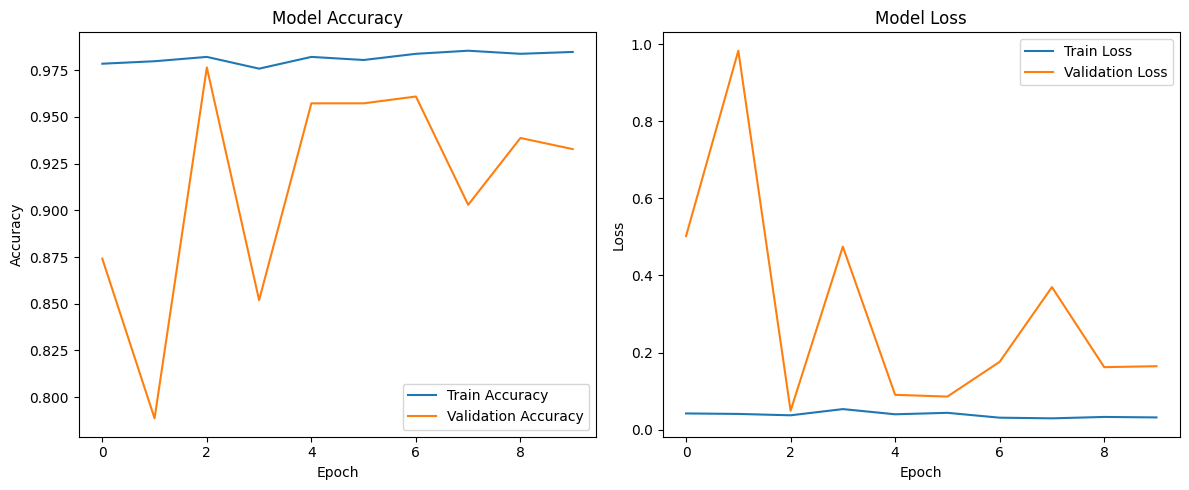

In [ ]:
import matplotlib.pyplot as plt

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train_categorical, epochs=10, validation_data=(X_test, y_test_categorical), batch_size=32)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

95/95 [==============================] - 1s 2ms/step


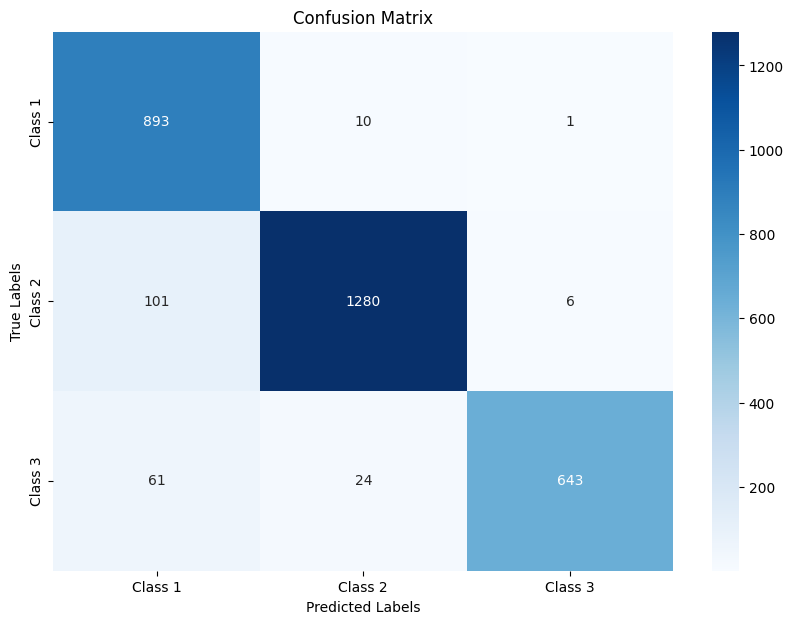

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_categorical, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

In [ ]:
metrics = precision_recall_fscore_support(y_true_classes, y_pred_classes, average=None, labels=[0, 1, 2])
accuracies = np.diag(cm) / np.sum(cm, axis=1)

activities = ['Crossover', 'Between the Legs','In and Out']


results = pd.DataFrame({
    'Activity': activities,
    'Accuracy': accuracies,
    'Recall': metrics[1],
    'Precision': metrics[0],
    'F1 score': metrics[2]
})


overall_metrics = precision_recall_fscore_support(y_true_classes, y_pred_classes, average='weighted')
overall_accuracy = np.sum(np.diag(cm)) / np.sum(cm)
overall_results = pd.DataFrame({
    'Activity': ['Overall'],
    'Accuracy': [overall_accuracy],
    'Recall': [overall_metrics[1]],
    'Precision': [overall_metrics[0]],
    'F1 score': [overall_metrics[2]]
})

results = pd.concat([results, overall_results], ignore_index=True)


In [ ]:
results['Accuracy'] = (results['Accuracy'] * 100).round(1).astype(str) + '%'
results['Recall'] = (results['Recall'] * 100).round(1).astype(str) + '%'
results['Precision'] = (results['Precision'] * 100).round(1).astype(str) + '%'
results['F1 score'] = (results['F1 score'] * 100).round(1).astype(str) + '%'

print(results)


           Activity Accuracy Recall Precision F1 score
0         Crossover    98.8%  98.8%     84.6%    91.2%
1  Between the Legs    92.3%  92.3%     97.4%    94.8%
2        In and Out    88.3%  88.3%     98.9%    93.3%
3           Overall    93.3%  93.3%     94.0%    93.3%
